# CosmoGrid Comparison

CosmoGrid is a large suite of N-body simulations spanning a wide range of cosmological parameters. This notebook validates our PM pipeline by comparing convergence maps and power spectra against CosmoGrid reference data.

The comparison tests whether our fast PM approximation reproduces the structure seen in full N-body simulations at the power spectrum level.

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


ERROR:2026-02-10 16:06:42,248:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_UNKNOWN


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load CosmoGrid Reference Data

`load_cosmogrid_lc` reads compressed HEALPix shells and the associated cosmology from a CosmoGrid simulation directory. The returned `Catalog` contains both the `SphericalDensity` lightcone and the `jc.Cosmology` used to run that simulation.

In [2]:
cosmogrid_path = "/home/wassim/Projects/NBody/Simulations/CosmoGrid/raw/cosmo_000001/run_0/"

catalog = ffi.io.load_cosmogrid_lc(
    cosmogrid_path,
    max_shells=8,
    ud_nside=512,
)

cg_lightcone = catalog.field
cg_cosmo = catalog.cosmology

print(f"CosmoGrid lightcone shape: {cg_lightcone.shape}")
print(f"CosmoGrid NSIDE: {cg_lightcone.nside}")
print(f"CosmoGrid cosmology: Omega_c={float(cg_cosmo.Omega_c):.4f}, h={float(cg_cosmo.h):.4f}, sigma8={float(cg_cosmo.sigma8):.4f}")
print(f"Scale factors: {cg_lightcone.scale_factors}")

CosmoGrid lightcone shape: (8, 3145728)
CosmoGrid NSIDE: 512
CosmoGrid cosmology: Omega_c=0.2538, h=0.7300, sigma8=0.9000
Scale factors: [[0.9937185 ]
 [0.9812898 ]
 [0.9689705 ]
 [0.95675707]
 [0.94464666]
 [0.93263614]
 [0.9207224 ]
 [0.9089023 ]]


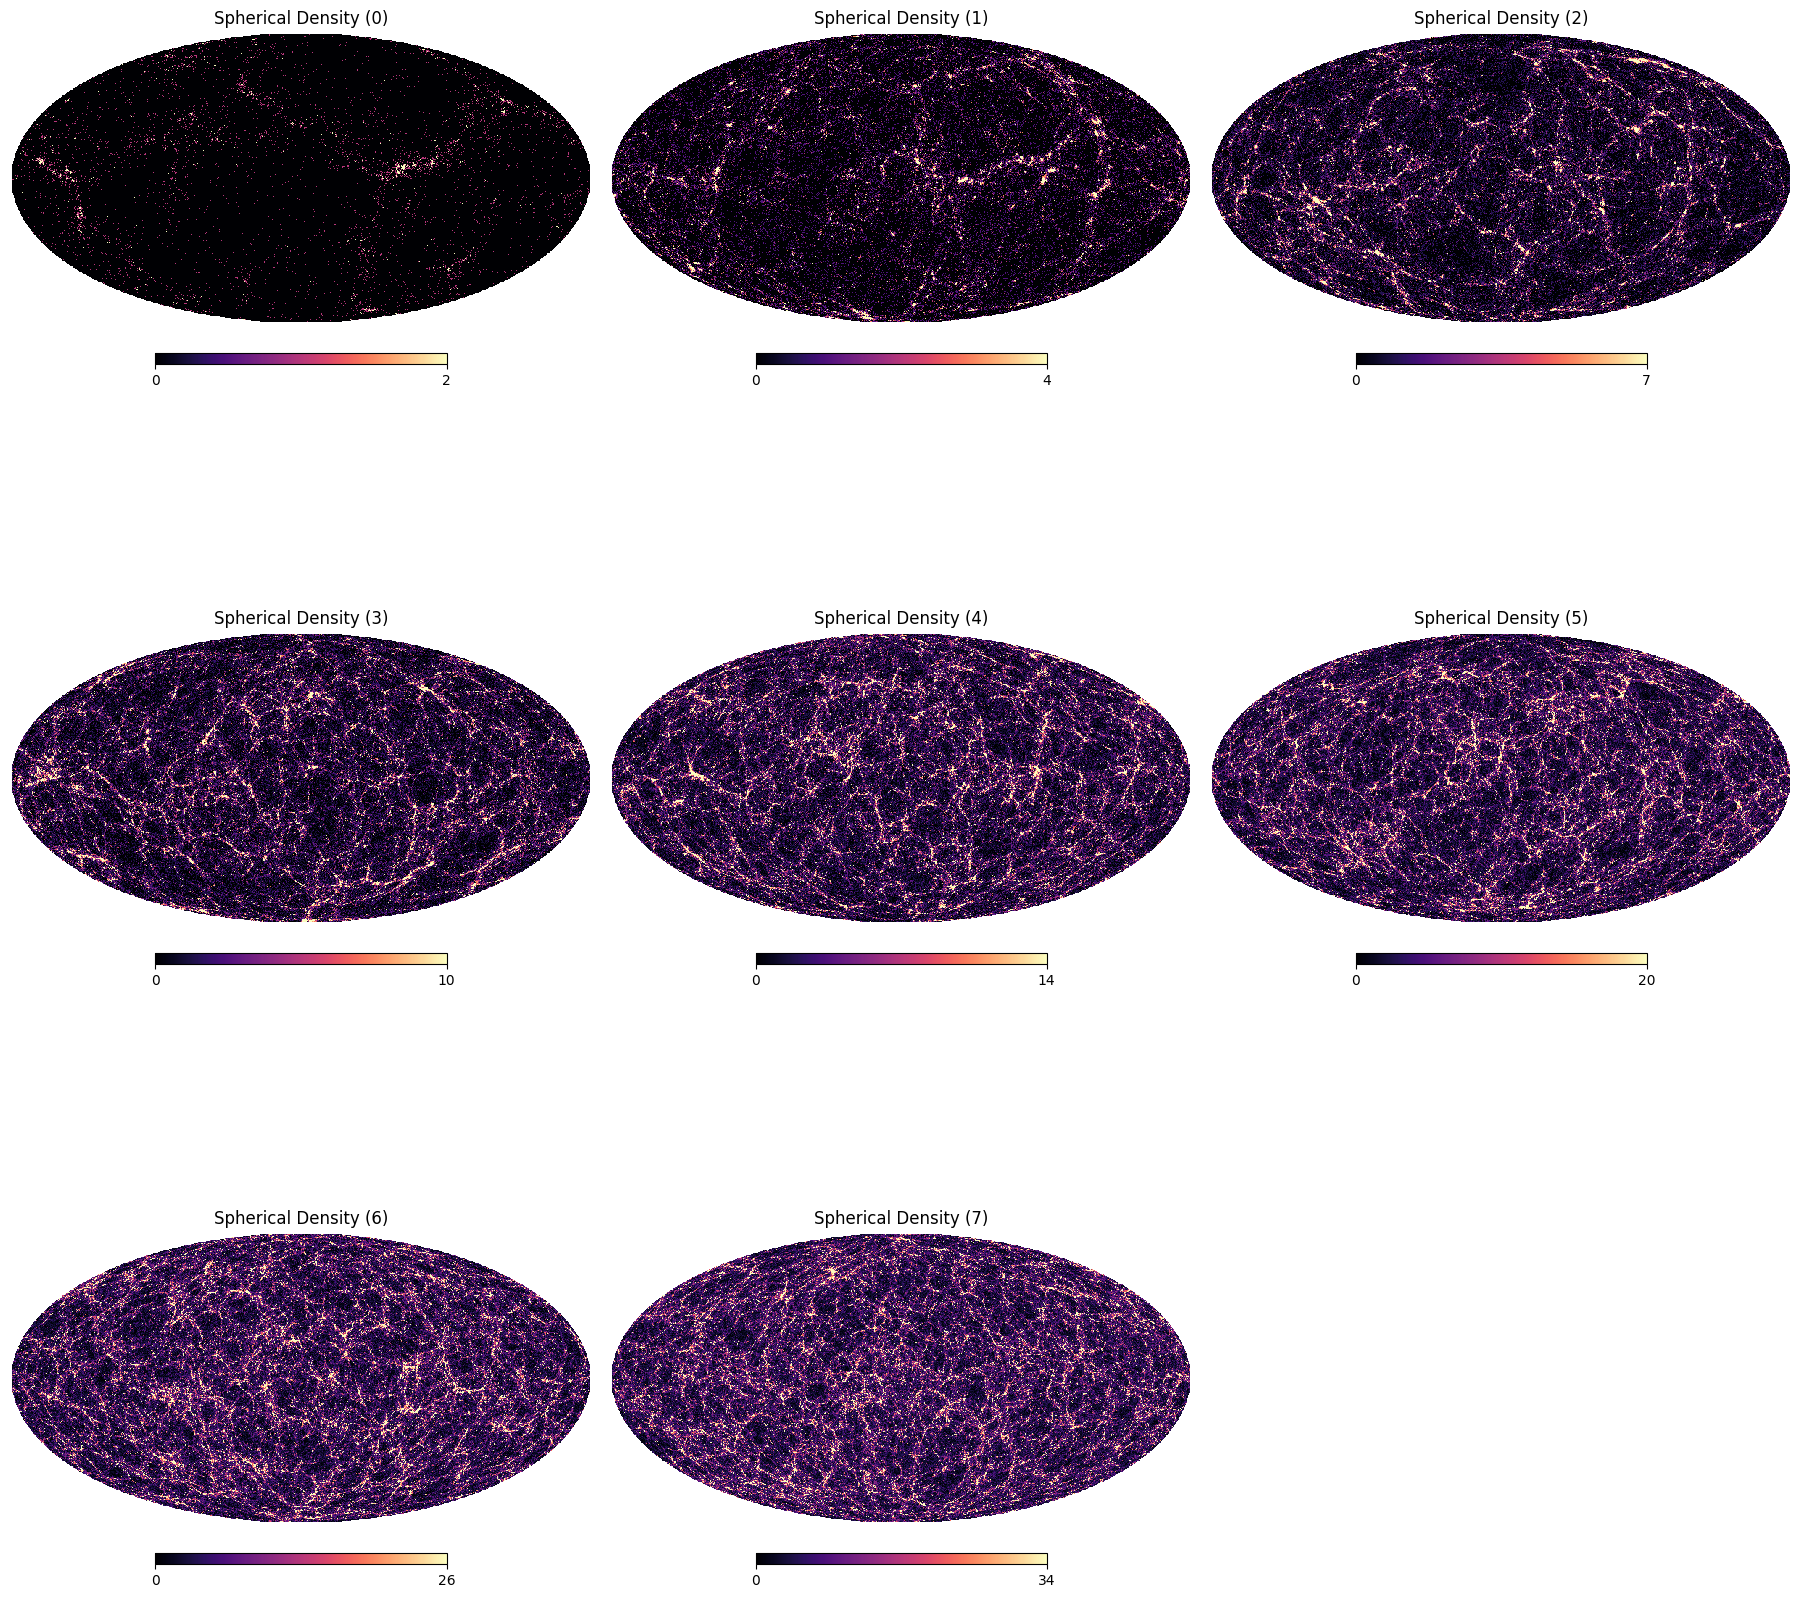

In [3]:
cg_lightcone.show()

## Run Matching PM Simulation

To make a fair comparison, we run our PM pipeline with the same cosmology as the CosmoGrid simulation. The box size and shell structure are matched to the CosmoGrid output.

In [4]:
key = jax.random.PRNGKey(0)
mesh_size = (128, 128, 128)
box_size = tuple([float(cg_lightcone.box_size[0])] * 3)
nside = cg_lightcone.nside
nb_shells = cg_lightcone.shape[0]

print(f"Matching PM config: box={box_size[0]:.0f} Mpc/h, nside={nside}, shells={nb_shells}")

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cg_cosmo,
    nside=nside,
)

dx, p = ffi.lpt(cg_cosmo, initial_field, scale_factor_spec=0.1, order=1)

solver = ffi.EfficientDriftDoubleKick(
    pgd_kernel=ffi.NoCorrection(),
    interp_kernel=ffi.OnionTiler(painting=ffi.PaintingOptions(target="spherical", scheme="bilinear")),
)

pm_lightcone = ffi.nbody(
    cg_cosmo, dx, p,
    t1=1.0, dt0=0.05,
    nb_shells=nb_shells,
    solver=solver,
)

print(f"PM lightcone shape: {pm_lightcone.shape}")

Matching PM config: box=4876 Mpc/h, nside=512, shells=8


PM lightcone shape: (8, 3145728)


## Apply Lensing

Compute convergence maps for both the CosmoGrid and our PM lightcones using the Born approximation.

In [5]:
nz_sources = ffi.io.get_stage3_nz_shear()
print(f"Number of tomographic bins: {len(nz_sources)}")

kappa_cg = ffi.born(cg_cosmo, cg_lightcone, nz_shear=nz_sources)
kappa_pm = ffi.born(cg_cosmo, pm_lightcone, nz_shear=nz_sources)

print(f"CosmoGrid kappa shape: {kappa_cg.shape}")
print(f"PM kappa shape: {kappa_pm.shape}")

Number of tomographic bins: 4


CosmoGrid kappa shape: (4, 3145728)
PM kappa shape: (4, 3145728)


## Compare Power Spectra

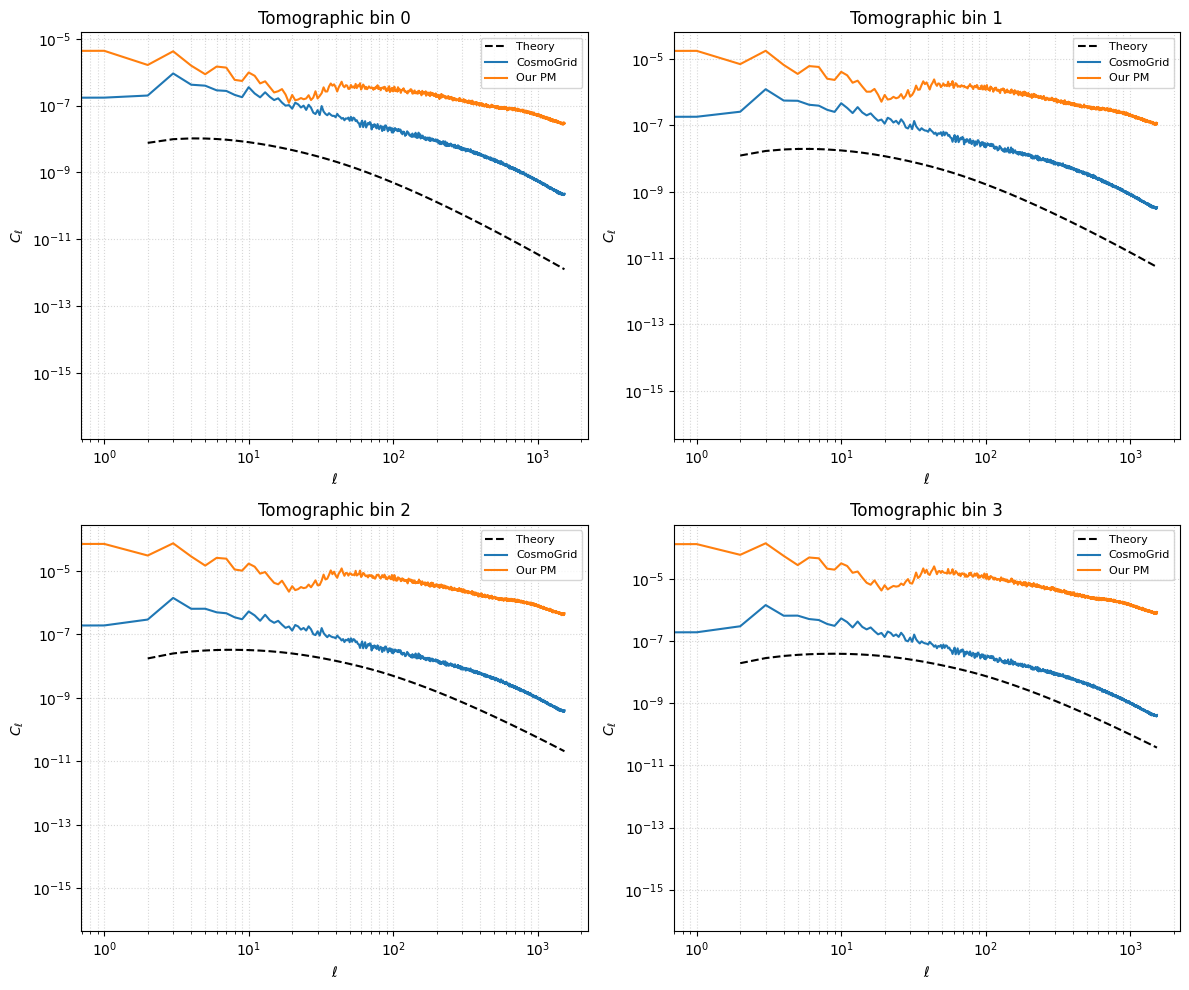

In [6]:
LMAX = 3 * nside - 1
ells = jnp.arange(2, LMAX)

theory_cl = ffi.compute_theory_cl(
    cg_cosmo, ell=ells, z_source=nz_sources,
    probe_type="weak_lensing", nonlinear_fn="linear", cross=False,
)

cl_cg = kappa_cg.angular_cl(method="healpy")
cl_pm = kappa_pm.angular_cl(method="healpy")

n_bins = len(nz_sources)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(n_bins):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label=["Theory"], color="black", linestyle="--")
    cl_cg[i].plot(ax=axes[i], logx=True, logy=True, label=["CosmoGrid"], color="tab:blue")
    cl_pm[i].plot(ax=axes[i], logx=True, logy=True, label=["Our PM"], color="tab:orange")
    axes[i].set_title(f"Tomographic bin {i}")
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

## Transfer Function and Coherence

Quantify the agreement between CosmoGrid and our PM using the transfer function $T(\ell) = \sqrt{C_\ell^{\mathrm{PM}} / C_\ell^{\mathrm{CG}}}$ and the cross-coherence.

In [7]:
# TODO(human): Implement the transfer function interpretation
# Given:
#   - cl_cg: PowerSpectrum with n_bins spectra (CosmoGrid)
#   - cl_pm: PowerSpectrum with n_bins spectra (our PM)
#   - theory_cl: PowerSpectrum with n_bins spectra (linear theory)
#   - n_bins: number of tomographic bins
#
# Compute and plot:
#   1. Transfer function T(ell) = sqrt(C_ell_PM / C_ell_CG)
#      for each tomographic bin
#   2. The ratio C_ell_PM / C_ell_theory and C_ell_CG / C_ell_theory
#   3. Identify the ell range where T(ell) ~ 1 (good agreement)
#      and where it deviates (resolution effects)
#
# Consider: What causes T(ell) < 1 at high ell?
# Why might T(ell) > 1 at some scales?
# How does the agreement depend on the tomographic bin?

def interpret_transfer_function(cl_cg, cl_pm, theory_cl, n_bins):
    pass  # Replace with your implementation


interpret_transfer_function(cl_cg, cl_pm, theory_cl, n_bins)